# 9. Supervised Machine Learning Techniques Assignment I 
-- Chuying Tang

In this report, we will use H2O module in Python to build (1) the GBM (Gradient Boosting Machine) model and (2) the Deep Learning with the mortgage probability of default data. The criteria for the models include ROC and the cumulative Lift. For each kind of model, we will use grid search to find out the hyper-parameters for models and also select or drop the variables to improve the model performance.



# Table of Contents <a class="anchor" id="0"></a>
- <b>[1. Data Preparation](#1)</b>
- <b>[2. H2O Introduction](#2)</b>
- <b>[3. Sample Model & Metrics Functions](#3)</b>
- <b>[4. GBM (Gradient Boosting Machine) Model](#4)</b>
- <b>[5. Deep Learning](#5)</b>
- <b>[6. Conclusion](#6)</b>

       
  <p>&nbsp;</p>

In [4]:
!pip install h2o
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.2 MB 51 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.1-py2.py3-none-any.whl size=177276478 sha256=6e1e46aad56d720329fd55607c794dd190d2a11b3cf91a69d9ac27d6fd74c76d
  Stored in directory: /root/.cache/pip/wheels/a1/a1/d9/bb37df368c4635a707e7362d1088450b606041f05aeba5f173
Successfully built h2o
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=7fe906509ed09a29ad0be323237dba3b3db9c8104162bfaad5a78aaecbc40d90
  Stored 

In [5]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

import h2o
import math

## 1. Data Preparation <a class="anchor" id="1"></a>

In [7]:
# load data
# path = '/Users/mac/Downloads/' 
# data = pd.read_csv(path + 'XYZloan_default_selected_vars.csv')  
data = pd.read_csv('XYZloan_default_selected_vars.csv') 
data.tail()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
79995,79995,79996,79996,0,39,2,1,12,2017/5/7 13:44,android,...,15.0,8.0,864.0,684.0,1261.0,764.0,2600.0,1074.0,11.0,OPPO
79996,79996,79997,79997,0,31,1,4,12,2017/6/2 15:54,ios,...,25.0,25.0,6177.0,6177.0,6426.0,6426.0,6426.0,6426.0,6.0,IPHONE7
79997,79997,79998,79998,0,37,1,1,12,2017/7/9 8:40,android,...,14.0,13.0,1116.0,1116.0,2061.0,2061.0,2501.0,2061.0,12.0,VIVO
79998,79998,79999,79999,0,38,2,1,12,2017/5/9 10:19,android,...,5.0,2.0,25.0,0.0,498.0,343.0,514.0,343.0,6.0,XIAOMI
79999,79999,80000,80000,1,25,1,3,12,2017/4/27 18:36,h5,...,9.0,9.0,129.0,129.0,167.0,167.0,167.0,167.0,7.0,WEB


In [8]:
# split the data for modeling
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.20, random_state=42) 

In [9]:
train.shape

(64000, 89)

In [10]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [11]:
# change the colum names of var dataframe
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [12]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0,int64,Un
1,Unnamed: 0.1,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [13]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [14]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [15]:
train['loan_default'].value_counts(dropna=False)

0    51662
1    12338
Name: loan_default, dtype: int64

In [16]:
target='loan_default'
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

## 2. H2O Introduction <a class="anchor" id="2"></a>

In [17]:
# h2o.init()
h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuk56g13n
  JVM stdout: /tmp/tmpuk56g13n/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpuk56g13n/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,"28 days, 14 hours and 50 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_tyowii
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## 3. Sample Model & Metrics Functions <a class="anchor" id="3"></a>

In [18]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [19]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
# Build and train the model:
gbm_v1 = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=1111,
                                        keep_cross_validation_predictions = True)
gbm_v1.train(x=predictors, y=target, training_frame=train_hex)
gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [TD054, TD051, TD062, CR012, TD048, AP005, TD044, TD055]
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1666069296297_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          19902                  5            5            5             14            32            24.52

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.11729715715031569
RMSE: 0.34248672550964027
MAE: 0.2574703333878915
RMSLE: 0.23809549962075616
Mean Residual Deviance: 0.11729715715031569

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.14974899998965863
RMSE: 0.386974159330644
MAE: 0.29161135855580456
RMSLE: 0.27218780487186883
Mean Residual Deviance: 0.14974899998965863

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.291691   0.00338432  0.289275      0.294215      0.28735       0.292104      0.29551
mean_residual_deviance  0.149845   0.00354289  0.146084      0.152786      0.14689       0.14933       0.154136
mse                     0.149845   0.00354289  0.146084      0.152786      0.14689       0.14933       0.154136
r2                      0.0236069  0.0184093   0.0222406     0.017372      0.0487877     -0.00140436   0.0310386
residual_deviance       0.149845   0.00354289  0.146084      0.152786      0.14689       0.14933       0.154136
rmse                    0.387077   0.00457274  0.382209      0.390878      0.383262      0.386433      0.392602
rmsle                   0.272228   0.00284889  0.270275      0.274336      0.2682        0.273682      0.274649

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2022-10-18 05:02:17  8.630 sec   0.0                0.3916822878921649   0.30683002929687975  0.15341501464844076
     2022-10-18 05:02:17  8.677 sec   1.0                0.38881417366859106  0.3044736587186344   0.1511764616455893
     2022-10-18 05:02:17  8.724 sec   2.0                0.38654417667336927  0.3024822064326145   0.14941640052009292
     2022-10-18 05:02:17  8.771 sec   3.0                0.3839626471125789   0.30019924632506445  0.1474273143776988
     2022-10-18 05:02:17  8.807 sec   4.0                0.38209685481946504  0.2983950267639011   0.14599800646292732
     2022-10-18 05:02:17  8.838 sec   5.0                0.38006991510124905  0.2964135157619603   0.14445314036507068
     2022-10-18 05:02:17  8.865 sec   6.0                0.3781942969958751   0.29460710709448906  0.14303092628020417
     2022-10-18 05:02:17  8.892 sec   7.0                0.37689411054496824  0.29329655511770397  0.14204917056348274
     2022-10-18 05:02:17  8.940 sec   8.0                0.37550339267635735  0.2918395955150481   0.14100279791145462
     2022-10-18 05:02:18  8.989 sec   9.0                0.3739888209805933   0.29020808162284084  0.13986763821845424
---  ---                  ---         ---                ---                  ---                  ---
     2022-10-18 05:02:19  10.449 sec  41.0               0.34680602329079246  0.26167232884061375  0.12027441779077368
     2022-10-18 05:02:19  10.480 sec  42.0               0.34622720273183577  0.26101626161151215  0.1198732759115117
     2022-10-18 05:02:19  10.499 sec  43.0               0.34549254873897395  0.26035312230099406  0.11936510123415228
     2022-10-18 05:02

In [20]:
predictions = gbm_v1.predict(test_hex)
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["MOTOROLA"]
  warnings.warn(w)


,loan_default,predict
0,0,0.311790
1,0,0.232343
2,0,0.269055
3,0,0.116890
4,0,0.174470


Here we define functions to generate gains table and ROC/AUC. We will first use a portion of dataset to validate that our self defined functions are application. We will then apply the functions to the whole dataset. 

### Gains Table
A Gains Chart can serve two great purposes to help our business strategies: (i) selecting the better-performing model, and (ii) deciding which segments to target. In this case, we will use it to select the better-performing model to detect the loan faults.

In [21]:
# define a function to conduct gains table
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(gbm_v1)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["MOTOROLA"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,160,57,103,160,57,103,0.19,0.08,30.0,1.90,11.0,35.62
1,160,34,126,320,91,229,0.30,0.18,60.0,1.52,12.0,28.44
2,160,44,116,480,135,345,0.45,0.27,90.0,1.50,18.0,28.12
3,160,33,127,640,168,472,0.56,0.36,120.0,1.40,20.0,26.25
4,160,31,129,800,199,601,0.66,0.46,150.0,1.33,20.0,24.88
5,160,26,134,960,225,735,0.75,0.57,180.0,1.25,18.0,23.44
6,160,17,143,1120,242,878,0.81,0.68,210.0,1.15,13.0,21.61
7,160,25,135,1280,267,1013,0.89,0.78,240.0,1.11,11.0,20.86
8,160,18,142,1440,285,1155,0.95,0.89,270.0,1.06,6.0,19.79


### ROC (Receiver Operating Characteristic) & AUC (Area Under the Curve)
The receiver operating characteristic (ROC) curve is one of the most effective evaluation metrics because it visualizes the accuracy of predictions for a whole range of cutoff values.If we had a perfect model, the ROC curve would pass through the upper left corner — indicating no error. A better model is when the ROC is close to the upper left corner.  
The most important parameter that can be obtained from a ROC curve is the Area Under the Curve (AUC). For a perfect model, the area under the curve would be 1.0.

In [22]:
# define a functiont to calculate ROC_AUC
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df)['p1'].as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

In [23]:
# ROC_AUC(gbm_v1,test_hex,'loan_default')

Figure above shows that the AUC is 0.6318.

#### [Back to the top](#0)

## 4. GBM (Gradient Boosting Machine) Model
<a class="anchor" id="4"></a>
Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. 

In [24]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

# convert target variable into factor for binary classification
train_hex[target] = train_hex[target].asfactor()
test_hex[target] = test_hex[target].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
from h2o.estimators import H2OGradientBoostingEstimator
# Build and train the model
gbm_v2 = H2OGradientBoostingEstimator(nfolds=5,
                                      seed=1234,
                                      keep_cross_validation_predictions = True)
gbm_v2.train(x=predictors, y=target, training_frame=train_hex)

gbm Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1666069296297_3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          27639                  5            5            5             25            32            30.36

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1405540007167919
RMSE: 0.3749053223372428
LogLoss: 0.44487085780534086
Mean Per-Class Error: 0.3459109929970573
AUC: 0.7161161233693032
AUCPR: 0.399979174975966
Gini: 0.4322322467386064

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2100321204798557
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      36472  15190  0.294    (15190.0/51662.0)
1      4908   7430   0.3978   (4908.0/12338.0)
Total  41380  22620  0.314    (20098.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.210032     0.425082  223
max f2                       0.144347     0.581692  301
max f0point5                 0.300513     0.4104    143
max accuracy                 0.40895      0.8145    78
max precision                0.885235     1         0
max recall                   0.0472048    1         397
max specificity              0.885235     1         0
max absolute_mcc             0.23975      0.258365  195
max min_per_class_accuracy   0.196871     0.655027  238
max mean_per_class_accuracy  0.193191     0.657619  242
max tns                      0.885235     51662     0
max fns                      0.885235     12337     0
max fps                      0.0389324    51662     399
max tps                      0.0472048    12338     397
max tnr                      0.885235     1         0
max fnr                      0.885235     0.999919  0
max fpr                      0.0389324    1         399
max tpr                      0.0472048    1         397

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.29 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.475753           3.95526   3.95526            0.7625           0.544999   0.7625                      0.544999            0.0395526       0.0395526                  295.526   295.526            0.0366104
2        0.02                        0.43048            2.99887   3.47706            0.578125         0.451204   0.670312                    0.498101            0.0299887       0.0695413                  199.887   247.706            0.0613728
3        0.03                        0.403113           2.63414   3.19609            0.507812         0.41617    0.616146                    0.470791            0.0263414       0.0958826                  163.414   219.609            0.0816168
4        0.04                        0.383884           2.36667   2.98873            0.45625          0.393166   0.576172                    0.451385            0.0236667       0.119549                   136.667   198.873            0.0985475
5        0.05                        0.368431           2.4153    2.87405            0.465625         0.375784   0.554063      

In [26]:
createGains(gbm_v2)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/28 17:20", "2017/3/28 18:58", "2017/3/28 20:20", "2017/3/28 22:38", "2017/3/29 11:14", "2017/3/29 14:05", "2017/3/29 15:33", "2017/3/29 18:33", "2017/3/29 19:01", ...7908 not listed..., "2017/7/9 4:43", "2017/7/9 5:59", "2017/7/9 6:34", "2017/7/9 7:35", "2017/7/9 8:16", "2017/7/9 8:20", "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 9:46"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["EYU", "HONGLAJIAO", "IPAD3", "KINGSUN", "MANN", "PHILIPS", "PROTRULY", "REDGOO", "VOLTE"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,474,1126,1600,474,1126,0.15,0.09,315.0,1.50,6.0,29.62
1,1600,482,1118,3200,956,2244,0.30,0.17,630.0,1.52,13.0,29.88
2,1600,492,1108,4800,1448,3352,0.46,0.26,945.0,1.53,20.0,30.17
3,1600,367,1233,6400,1815,4585,0.58,0.36,1260.0,1.44,22.0,28.36
4,1600,221,1379,8000,2036,5964,0.65,0.46,1575.0,1.29,19.0,25.45
5,1600,208,1392,9600,2244,7356,0.71,0.57,1890.0,1.19,14.0,23.38
6,1600,225,1375,11200,2469,8731,0.78,0.68,2205.0,1.12,10.0,22.04
7,1600,249,1351,12800,2718,10082,0.86,0.78,2520.0,1.08,8.0,21.23
8,1600,224,1376,14400,2942,11458,0.93,0.89,2835.0,1.04,4.0,20.43


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'AP005' has levels not trained on: ["2017/3/22 15:12", "2017/3/28 17:20", "2017/3/28 18:58", "2017/3/28 20:20", "2017/3/28 22:38", "2017/3/29 11:14", "2017/3/29 14:05", "2017/3/29 15:33", "2017/3/29 18:33", "2017/3/29 19:01", ...7908 not listed..., "2017/7/9 4:43", "2017/7/9 5:59", "2017/7/9 6:34", "2017/7/9 7:35", "2017/7/9 8:16", "2017/7/9 8:20", "2017/7/9 8:31", "2017/7/9 8:32", "2017/7/9 8:37", "2017/7/9 9:46"]
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["EYU", "HONGLAJIAO", "IPAD3", "KINGSUN", "MANN", "PHILIPS", "PROTRULY", "REDGOO", "VOLTE"]
  warnings.warn(w)


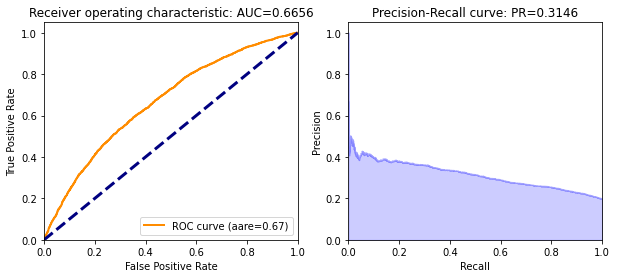

In [27]:
ROC_AUC(gbm_v2,test_hex,'loan_default')

The orange curve is the ROC curve. The above plot with 0.6656 ROC means that the model result is slightly better than a completely random draw(blue line). We will use this model as a basic model for the following model improvement.

### Hyper-parameter Tunning
Here we will use grid search to find the optimized hyper-parameter.
 - We want to know what value of max_depth and ntree to use because it has a big impact on the model training time and optimal values depend strongly on the dataset. 
 - We'll do a quick Cartesian grid search to get a rough idea of good candidate max_depth values. Each model in the grid search will use early stopping to tune the number of trees using the validation set AUC, as before. We'll use learning rate annealing to speed up convergence without sacrificing too much accuracy.

In [31]:
#GBM hyperparameters
gbm_params = {"ntrees" : [100,200,300], 
              "max_depth": [4, 6, 8, 10, 12], 
              'learn_rate':[0.01, 0.02, 0.03]}
search_criteria_tune = {"strategy": "RandomDiscrete", 
                        "max_models": 20, 
                        "seed": 12345}

In [32]:
from h2o.grid.grid_search import H2OGridSearch

#Build initial GBM Model
gbm_model=H2OGradientBoostingEstimator(nfolds=5,
                                       fold_assignment="Modulo",
                                       keep_cross_validation_predictions=True,
                                       seed=1234)
#Build grid search with previously made GBM and hyper parameters
gbm_grid1 = H2OGridSearch(gbm_model, 
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params,
                          search_criteria=search_criteria_tune)

In [ ]:
#Train grid search
gbm_grid1.train(x=predictors, y=target, training_frame=train_hex)

gbm Grid Build progress: |██

In [ ]:
# sort the grid models by decreasing AUC
gbm_grid_sorted = gbm_grid1.get_grid(sort_by='auc',decreasing=True)
print(gbm_grid_sorted)

It appears that max_depth values of 4 and 300 trees are best suited for this dataset.

In [ ]:
# Grab the top GBM model, chosen by validation AUC
best_gbm = gbm_grid_sorted.models[0]
best_gbm

In [ ]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
ROC_AUC(best_gbm,test_hex,'loan_default')

In [ ]:
createGains(best_gbm)

According to the graph above, we were able to get the AUC on a holdout test set from 66.56% range with the default model to 68.73% range after tuning.

### Featrue Selection with Variable importance

In [ ]:
# Retrieve the variable importance
varimp = best_gbm.varimp(use_pandas=True)

In [ ]:
# select the features that has variable importances higher than 0
feature_selected = varimp[varimp['relative_importance']>0]['variable'].tolist()
predictors_selected = feature_selected
feature_selected.append('loan_default')

In [ ]:
train_selected = train_hex[feature_selected]
test_selected = test_hex[feature_selected]

In [ ]:
from h2o.estimators import H2OGradientBoostingEstimator
# Build and train the model
gbm_v3 = H2OGradientBoostingEstimator(ntrees = 300,
                                      max_depth = 4, 
                                      nfolds=5,
                                      seed=1234,
                                      keep_cross_validation_predictions = True)
gbm_v3.train(x=predictors_selected, y=target, training_frame=train_selected)

In [ ]:
ROC_AUC(gbm_v3,test_selected,'loan_default')

In [ ]:
createGains(gbm_v3)

The AUC is 0.6641 and the highest lift is 1.61, smaller than the best model before, which means that the model with the selected variables does not perform well as expected. The reason may be that the model is over-fitting with less features.

#### [Back to the top](#0)

## 5. Deep Learning Model
<a class="anchor" id="5"></a>
Deep learning is a class of machine learning algorithms that uses multiple layers to model patterns in data. It is also called Artificial Neural Network (ANN) or Neural Network (NN). 

### 5.1 data preparation

In [ ]:
data[var[var['dtype']=='object']['varname']]

In [ ]:
if any(x in var[var['dtype']=='object']['varname'] for x in feature_selected):
    print("Duplicates found.")
else:
    print("No duplicates found.")

In [ ]:
data.AP005.head()

It appears that 'AP005' is datetime data. We will extract the useful information from this datetime variable for model building.

In [ ]:
data['AP005'] = pd.to_datetime(data['AP005'])

In [ ]:
data.AP005.head()

In [ ]:
data['AP005_year'] = data['AP005'].dt.year
data['AP005_month'] = data['AP005'].dt.month
data['AP005_week'] = data['AP005'].dt.week
data['AP005_day'] = data['AP005'].dt.day
data['AP005_hour'] = data['AP005'].dt.hour
data['AP005_minute'] = data['AP005'].dt.minute
data['AP005_dayofweek'] = data['AP005'].dt.dayofweek

In [ ]:
data.head()

In [ ]:
AP005_new = ['AP005_year', 
             'AP005_month', 
             'AP005_week', 
             'AP005_day', 
             'AP005_hour', 
             'AP005_minute', 
             'AP005_dayofweek']

In [ ]:
predictors_new = predictors + AP005_new
predictors_new.remove('AP005')
predictors_new.remove('AP006')
predictors_new.remove('MB007')

In [ ]:
# split the data for modeling
from sklearn.model_selection import train_test_split
train_dl, test_dl = train_test_split(data, test_size=0.20, random_state=1)
train_dl, valid_dl = train_test_split(train_dl, test_size=0.25, random_state=1) 

In [ ]:
train_dl = h2o.H2OFrame(train_dl)
valid_dl = h2o.H2OFrame(valid_dl)
test_dl = h2o.H2OFrame(test_dl)

# convert target variable into factor for binary classification
train_dl[target] = train_dl[target].asfactor()
valid_dl[target] = valid_dl[target].asfactor()
test_dl[target] = test_dl[target].asfactor()

### 5.2 Deep Learning Model
First we will train a basic DL model with default parameters. DL will infer the response distribution from the response encoding if not specified explicitly through the distribution argument.

In [ ]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
# Initialize and train the DL estimator:
dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1)
dl_fit1.train(x=predictors_new, y=target, training_frame=train_dl)

In [ ]:
ROC_AUC(dl_fit1,test_dl,'loan_default')

In [ ]:
createGains(dl_fit1)

The AUC of the initial DL model is 0.6517.

#### Train a DL with new architecture and more epochs

Next we will increase the number of epochs used in the GBM by setting epochs=20 (the default is 10). Increasing the number of epochs in a deep neural net may increase performance of the model. To automatically find the optimal number of epochs, we use H2O's early stopping functionality. Unlike the rest of the H2O algorithms, H2O's DL will use early by default, so we will first turn it off in the next example by setting stopping_rounds=0, for comparison.

In [ ]:
dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=20, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1)
dl_fit2.train(x=predictors_new, y=target, training_frame=train_dl)

In [ ]:
ROC_AUC(dl_fit2,test_dl,'loan_default')

The AUC increases to 0.6536 after setting the epoches.

#### Train a DL with early stopping
Using the same model parameters as dl_fit2, we will turn on early stopping and specify the stopping criterion. We will also pass a validation set, as is recommended for early stopping.

In [ ]:
dl_fit3 = H2ODeepLearningEstimator(model_id='dl_fit3', 
                                   epochs=20, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)
dl_fit3.train(x=predictors_new, y=target, training_frame=train_dl, validation_frame=valid_dl)

In [ ]:
ROC_AUC(dl_fit3,test_dl,'loan_default')

Compare the model performance of the three models using a test set and AUC

In [ ]:
dl_perf1 = dl_fit1.model_performance(test_dl)
dl_perf2 = dl_fit2.model_performance(test_dl)
dl_perf3 = dl_fit3.model_performance(test_dl)
# Retreive test set AUC
print(dl_perf1.auc())
print(dl_perf2.auc())
print(dl_perf3.auc())

Based on the result of AUC, the second model with more epochs nut no early stopping reach 0.6535, which is better than the other two. The added hyper-parameters do improve the model performance.

### 5.3 Grid Search for hyper_parameter tuning
Next we will explore some deep learning parameters in a random grid search. We will execute the grid search for 120 seconds.
 - **Learning Rate (LR)**: If the learning rate (LR) is too small, overfitting can occur. Large learning rates help to regularize the training but if the learning rate is too large, the training will diverge. Hence a grid search of short runs to find learning rates that converge or diverge is possible but we have another approach called “Cyclical learning rates (CLR)” by Leslie N. Smith.

In [ ]:
# DL hyperparameters
activation_opt = ["Rectifier", "RectifierWithDropout", "Maxout", "MaxoutWithDropout"] 
epochs = [20, 40, 60]
learning_rate =[0.1, 0.01, 0.001]
dl_params = {'activation': activation_opt, 
             'epochs': epochs, 
             'adaptive_rate': learning_rate}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 
                   'max_runtime_secs': 120, 
                   'seed':1}


In [ ]:
dl_grid = H2OGridSearch(model=H2ODeepLearningEstimator,
                        grid_id='dl_grid',
                        hyper_params=dl_params,
                        search_criteria=search_criteria)

dl_grid.train(x=predictors_new, y=target,
              training_frame=train_dl, 
              validation_frame=valid_dl, 
              hidden=[10,10],
              hyper_params=dl_params,
              search_criteria=search_criteria)

In [ ]:
dl_gridperf = dl_grid.get_grid(sort_by='auc', decreasing=True)

In [ ]:
# Grab the model_id for the top GBM model, chosen by validation AUC
best_dl_model = dl_gridperf.models[0]

In [ ]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance

dl_perf = best_gbm_model.model_performance(test_dl)
print(dl_perf.auc())

## 6. Conclusion <a class="anchor" id="6"></a>
We then splited the data in train, validation and test set. We trained a predictive model using GBM model from H2O, starting with a simple model, following with simple parameter tuning and then we used GridSearch to find the best parameters for the model, looking to maximize the AUC score for the validation set.

Finaly, with the best model, we atempted to predict the target value for the test data.

The AUC score for the test data was **0.698**.

#### Reference:
 - https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb
 - https://github.com/h2oai/h2o-tutorials/blob/master/h2o-open-tour-2016/chicago/intro-to-h2o.ipynb

#### [Back to the top](#0)